This is a notebook that lays out my code and analysis for the NYC Green Taxi Data. 

Author: Neel Parekh

Python: 3.6

Questions: np423@cornell.edu

In [198]:
%matplotlib inline

# requirements: 
# pip install seaborn (includes numpy, scipy, pandas, matplotlib)
# pip install sklearn

# standard package imports (all are standard in conda)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime # included in python3

# scipy signal processing imports
from scipy.signal import argrelextrema

# sklearn imports
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold

# Load Green Taxi Data

In [209]:
data_url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv' # provided URL where data lives
green_data = pd.read_csv(data_url).drop('Ehail_fee',axis=1) # no need for ehail_fee as it's all nulls anyway
print('Rows: {} \nColumns: {}'.format(green_data.shape[0], green_data.shape[1]))
print('Null Columns Removed: {}'.format('Ehail_fee'))
green_data.describe()

Rows: 1494926 
Columns: 20
Null Columns Removed: Ehail_fee


,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type
count,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494926e+06,1.494922e+06
mean,1.782045e+00,1.097653e+00,-7.383084e+01,4.069114e+01,-7.383728e+01,4.069291e+01,1.370598e+00,2.968141e+00,1.254320e+01,3.512800e-01,4.866408e-01,1.235727e+00,1.231047e-01,2.920991e-01,1.503215e+01,1.540559e+00,1.022353e+00
std,4.128570e-01,6.359437e-01,2.776082e+00,1.530882e+00,2.677911e+00,1.476698e+00,1.039426e+00,3.076621e+00,1.008278e+01,3.663096e-01,8.504473e-02,2.431476e+00,8.910137e-01,5.074009e-02,1.155316e+01,5.232935e-01,1.478288e-01
min,1.000000e+00,1.000000e+00,-8.331908e+01,0.000000e+00,-8.342784e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.750000e+02,-1.000000e+00,-5.000000e-01,-5.000000e+01,-1.529000e+01,-3.000000e-01,-4.750000e+02,1.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,-7.395961e+01,4.069895e+01,-7.396782e+01,4.069878e+01,1.000000e+00,1.100000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.160000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,-7.394536e+01,4.074674e+01,-7.394504e+01,4.074728e+01,1.000000e+00,1.980000e+00,9.500000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.176000e+01,2.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,-7.391748e+01,4.080255e+01,-7.391013e+01,4.079015e+01,1.000000e+00,3.740000e+00,1.550000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.830000e+01,2.000000e+00,1.000000e+00
max,2.000000e+00,9.900000e+01,0.000000e+00,4.317726e+01,0.000000e+00,4.279934e+01,9.000000e+00,6.031000e+02,5.805000e+02,1.200000e+01,5.000000e-01,3.000000e+02,9.575000e+01,3.000000e-01,5.813000e+02,5.000000e+00,2.000000e+00


# Explore Trip Distance Variable

Num outliers (>25mi): 1225


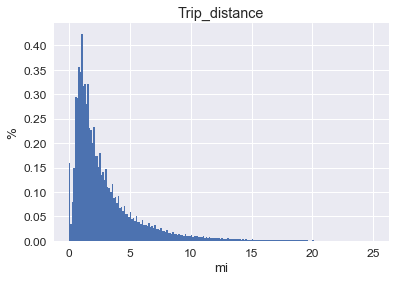

In [210]:
print('Num outliers (>25mi): {}'.format(len(green_data.loc[green_data['Trip_distance']>25])))
green_data.hist(column='Trip_distance',bins=200,range=(0, 25),normed=True)
plt.xlabel('mi')
plt.ylabel('%')
plt.show()

Notice how heavily skewed the data is toward short quick trips. This confirms that taxis are more often then not used for short quick trips rather than long trips. Also notice a strange pattern of spikes in the data, every portion of a mile. Let's dive deeper into that.  

In [211]:
def get_local_maximas(matrix):
    distances = matrix[:,1]
    counts = matrix[:,2]
    idxs = argrelextrema(counts, np.greater, order=3) # gets all idx who's value is greater than neighbors
    maximas = [ [idx, distances[idx], counts[idx]] 
                for idx in idxs[0] ]
    return np.array(maximas)

def get_local_minimas(matrix):
    distances = matrix[:,1]
    counts = matrix[:,2]
    idxs = argrelextrema(counts, np.less, order=3) # gets all idx who's value is greater than neighbors
    minimas = [ [idx, distances[idx], counts[idx]] 
                for idx in idxs[0] ]
    return np.array(minimas)

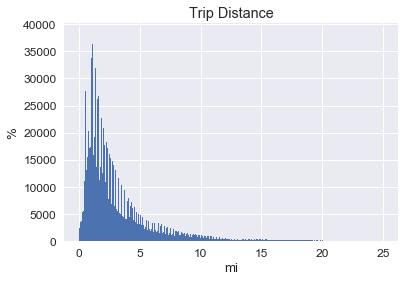

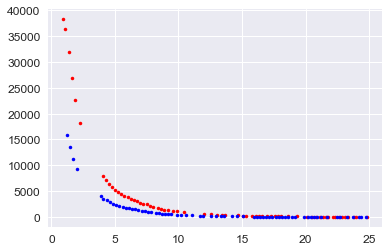

Ex. peak at:  5.0
Peak every 0.2 mi
Bin Intervals: 0.05 mi


In [240]:
# get the histogram indexes
aa = plt.hist(green_data['Trip_distance'],bins=500,range=(0,25))
plt.title('Trip Distance')
plt.xlabel('mi')
plt.ylabel('%')
plt.show()
orig_counts = np.array([ [ i, aa[1][i], aa[0][i] ] 
                  for i in range(len(aa[0])) ])

# get local maximas/minimas
maximas = get_local_maximas(orig_counts)
maximas_idxs, maximas_dist, maximas_counts = maximas[:,0], maximas[:,1], maximas[:,2]
minimas = get_local_minimas(orig_counts)
minimas_idxs, minimas_dist, minimas_counts = minimas[1:,0], minimas[1:,1], minimas[1:,2]

# plot the local maximas/minimas of the histogram
plt.figure()
plt.plot(maximas_dist, maximas_counts,'.r')
plt.plot(minimas_dist, minimas_counts,'.b')
plt.show()

print('Ex. peak at: ', aa[1][100])
print('Peak every {:.2} mi'.format(aa[1][104] - aa[1][100]))
print('Bin Intervals: {:.2} mi'.format(aa[1][104]-aa[1][103]))

### Analysis

If we increase the bin count, we notice a pattern in the recurring nature of peaks that are quite strange. This difference becomes less pronounced with longer rides, but does persist. Notice the actual distribution (minimas) and the odd local maximas decay on different functions (both seem to be exponential, though). Could this perhaps be due to the metering accuracy of some of the taxis? According to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml, which explains the rate calculations, taxis are metered every 0.20 miles. There are some peaks here every 0.20 miles, which would mean these taxis may only record distance up to that precision. Unfortunately, this is an imperfect analysis and the underlying reason may be convolved with many factors that are producing peaks at non-regular intervals at well. It would be interesting to simply ask the taxi metering comapnies how they are metered. 

# Explore Trip Distance per Hour of Day

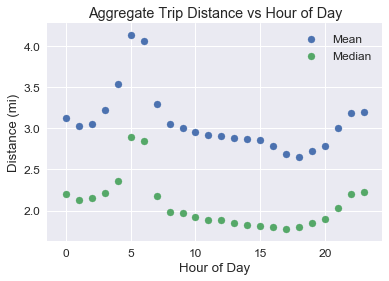

,count,mean,std,min,25%,50%,75%,max
pickup_hour,,,,,,,,
0,66894.0,3.121169,2.962916,0.0,1.1900,2.200,4.00,76.70
1,53558.0,3.022384,2.887631,0.0,1.1300,2.130,3.90,58.75
2,41019.0,3.053122,2.969238,0.0,1.1400,2.150,3.92,76.70
3,31481.0,3.218679,4.634737,0.0,1.1600,2.210,4.10,603.10
4,26250.0,3.534403,3.537727,0.0,1.2100,2.365,4.60,46.88
5,16558.0,4.138699,3.954212,0.0,1.3500,2.900,5.69,47.60
6,22456.0,4.063390,3.978774,0.0,1.3475,2.850,5.50,89.15
7,41690.0,3.289120,3.274904,0.0,1.1100,2.180,4.30,41.94
8,58638.0,3.050398,3.100000,0.0,1.0725,1.980,3.95,57.07


In [232]:
# get pickup date from the datestring
timedata = green_data['lpep_pickup_datetime']
green_data['pickup_hour'] = [datetime.datetime.strptime(s, "%Y-%m-%d  %H:%M:%S").hour for s in timedata]

# group by hour and find mean/median
grouped = green_data.groupby('pickup_hour')
mean_distance_per_hour = grouped['Trip_distance'].mean()
median_distance_per_hour = grouped['Trip_distance'].median()

# create the plot and observe more descriptive stats
plt.figure()
plt.scatter([i for i in range(len(mean_distance_per_hour))], mean_distance_per_hour)
plt.scatter([i for i in range(len(median_distance_per_hour))], median_distance_per_hour)
plt.legend(['Mean','Median'])
plt.title('Aggregate Trip Distance vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Distance (mi)')
plt.show()
grouped['Trip_distance'].describe()

### Analysis:

In the 5-6pm range, there is a global minima in trip distance. This is likely due to commuters getting off work and taking short rides home or to a happy hour, or taking the taxis to avoid weather conditions and drunk driving situations. On the opposite end of the spectrum, there's a local maxima at 5-6am, with trips almost a mile longer on average. If I were to run an ANOVA, I can guarantee there would be significance. Perhaps this is due to the fact that such early morning trips are generally faster as fewer cars are on the road.

Also note once again that the data is skewed - a lot of significantly shorter trips in each bin ensure the median is less than the mean. This is because taxis are more often used for short quick rides rather than long ones

# Explore Airport Trip Characteristics

Here I've used the RateCodeID to identify aiport trips. However, according to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml#AirportTrips, only Newark and JFK are metered with special codes - LaGuardia is considered normal metered fare. In order to include LaGuardia in this analysis, we could use the pickup/dropoff lat/long of LaGuardia (within a small radius) to define airport trips. Additionally note that, according to this link, the Newark and JFK rate codes only include trips to/from manhattan, not other areas of NYC. Hence, a lat/long identification of these airports would possibly identify more airport rides as well. 

In [215]:
# clean up dataframe of non-conforming values
green_data = green_data[green_data['RateCodeID'] != 99]
green_data = green_data[green_data['Total_amount'] > 0]
green_data = green_data.reset_index()

# analyze airport trips
print('1: {}\n2: {}\n3: {}\n4: {}\n5: {}\n6: {}'.format('StandardRate','JFK','Newark','NassauWestchester','Negotiated','Group'))
green_data.groupby('RateCodeID')[['Trip_distance','Total_amount','Tip_amount']].describe()


1: StandardRate
2: JFK
3: Newark
4: NassauWestchester
5: Negotiated
6: Group


Trip_distance                                                             Total_amount             ...                  Tip_amount                                                  
                   count       mean        std  min     25%     50%      75%     max        count       mean  ...      75%     max      count      mean       std  min  25%  50%     75%    max
RateCodeID                                                                                                    ...                                                                              
1              1451827.0   2.927789   2.900971  0.0  1.1000   1.980   3.7100  603.10    1451827.0  14.774211  ...    17.94  581.30  1451827.0  1.230471  2.301304  0.0  0.0  0.0   2.000  300.0
2                 4299.0  10.566943   9.129235  0.0  0.0100  16.860  18.4700   43.37       4299.0  59.770288  ...    67.34  350.00     4299.0  4.209311  7.860525  0.0  0.0  0.0  10.550  297.2
3                 1091.0  11.165940  11.214902  0.0  0.0400   8.850  20.5800  112.60       1091.0  61.796260  ...    97.80  203.30     1091.0  5.568185  9.414202  0.0  0.0  0.0  10.985  130.0
4                  922.0  14.919067  10.531832  0.0  8.2925  13.295  19.1775   94.38        922.0  68.995748  ...    87.55  497.55      922.0  5.302169  9.801503  0.0  0.0  0.0   8.045  120.0
5                30162.0   3.395444   5.162896  0.0  0.0200   1.835   4.6000  246.28      30162.0  21.940332  ...    22.75  500.00    30162.0  1.059682  4.499137  0.0  0.0  0.0   0.000  185.0
6                   32.0   1.412187   2.123585  0.0  0.0000   0.500   2.4500    7.80         32.0   3.875000  ...     4.30    6.30       32.0  0.000000  0.000000  0.0  0.0  0.0   0.000    0.0

[6 rows x 24 columns]

In [223]:
# Let's look at number of tips (and later, likelihood of tipping), given rate code
rides_with_tip = green_data.loc[green_data['Tip_amount'] > 0]
rides_with_tip.groupby('RateCodeID')['Tip_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
RateCodeID,,,,,,,,
1,595472.0,3.000025,2.757450,0.01,1.58,2.30,3.6600,300.0
2,1588.0,11.395359,9.241106,0.01,10.00,11.67,11.6700,297.2
3,395.0,15.379468,9.690800,0.02,10.00,15.09,19.1700,130.0
4,396.0,12.344949,11.697737,0.01,5.00,10.00,15.6675,120.0
5,4881.0,6.548277,9.442435,0.01,2.00,3.75,8.0000,185.0


In [227]:
print('Likelihood of Tipping:')
print('JFK: {}'.format(1588.0/4299.0))
print('Newark: {}'.format(395.0/1091.0))
print('NassauWestchester: {}'.format(396.0/922.0))

print('A Nassau passenger is {:.2}x more likely to tip than an airport passenger'.format( (396.0/922.0)/(0.5*395.0/1091.0 + 0.5*1588.0/4299.0) ))

Likelihood of Tipping:
JFK: 0.3693882298208886
Newark: 0.3620531622364803
NassauWestchester: 0.42950108459869846
A Nassau passenger is 1.2x more likely to tip than an airport passenger


### Analysis:

Trips to the Airports or NassauWestchester (i'll call it N/W) are often much longer and more expensive than those in any other rate code. This makes sense, as these three codes are the codes allocated for drivers to be complensated for travelling an excessive distance outside of the main metro area (and I guess also for dealing with the extra airport hassle). We can further observe that the percent of passangers that tip when travelling with N/W is higher than those to airports, by a factor of 1.2. This may be due to a variety of reasons, such as international tipping standards more likely in play for airport trips (as they are likely carrying international passengers) or N/W people not wanting to poorly tip someone who now likely knows their home address. 

# Create a Predictive Model for Passenger Tipping

## Clean up the data to be fed into a model

In [241]:
# add percent tip column to dataframe. This is tip amount divided by total amount charged to the customer. 
green_data['percent_tip'] = green_data['Tip_amount'] / green_data['Total_amount']

In [242]:
# create dummy variable columns
# must feed in dummy binary columns as the categorical numbers have no relational meaning in real life, 
# but the model will interpret a category of 2 to be related to a category of 1 by a factor of +1

# Note that we are creating two dummies for a single binary column. 
# Similarly, we are overdefining the RateCodeID by creating 6 dummies (5 is sufficient)
# Although I don't recommend this, if we are using lasso later, the extra column should drop out anyway.

df1 = pd.get_dummies(green_data['VendorID'])
df2 = pd.get_dummies(green_data['RateCodeID'])
df3 = pd.get_dummies(green_data['Trip_type ']) # <-- note the weird space in the column name

# Rename the columns for clarity and add them back to the main df
df1.columns = ['V1','V2']
df2.columns = ['StandardRate','JFK','Newark','NassauWestchester','Negotiated','Group']
df3.columns = ['Street-hail', 'Dispatch']
green_data[df1.columns] = df1
green_data[df2.columns] = df2
green_data[df3.columns] = df3

In [243]:
# create model inputs and outputs
model_input_cols = []
model_input_cols.extend(list(df1.columns))  
model_input_cols.extend(list(df2.columns))
model_input_cols.extend(list(df3.columns))
model_input_cols.extend(['dropoff_hour','Passenger_count','Trip_distance','Fare_amount','Tolls_amount'])
model_input_data = green_data[model_input_cols]
model_output_data = green_data['percent_tip']

In [244]:
# check to make sure we are only inserting clean data into the model
print(model_input_data.isnull().values.any())
model_input_data[model_input_data.isnull().any(axis=1)]
print(model_output_data.isnull().values.any())

False
False


In [245]:
## This was a check to understand where we need to clean up the data
# print(green_data[['Tip_amount','Total_amount','percent_tip']].loc[173,:])
# print()
# print(green_data.loc[173,:])
# print()
# print(green_data.loc[green_data['Total_amount'] == 0])

In [246]:
# we can also try polynomial features (i.e. a, b, c, a*b, a*c, b*c, etc.) 
# to get more insight into highly correlated features that together may explain a lot of variation in output data. 
PF = PolynomialFeatures(degree=2, interaction_only=True) # interactions only, we don't care about a^2 and b^2, etc.
poly_input_data = PF.fit_transform(model_input_data)
poly_input_data.shape # note that we end up with 121 features.

(1488333, 121)

## Explore the Data Before Creating Models

In [247]:
green_data['percent_tip'].mean()

0.06663840952427097

So the average tip is 6.67%. Lets see which variables are correlated with the percent tip we just calculated

In [248]:
# This is here to remove useless columns before creating the correlations heatmap
green_data = green_data.drop(['Store_and_fwd_flag','RateCodeID','VendorID'],axis=1) 

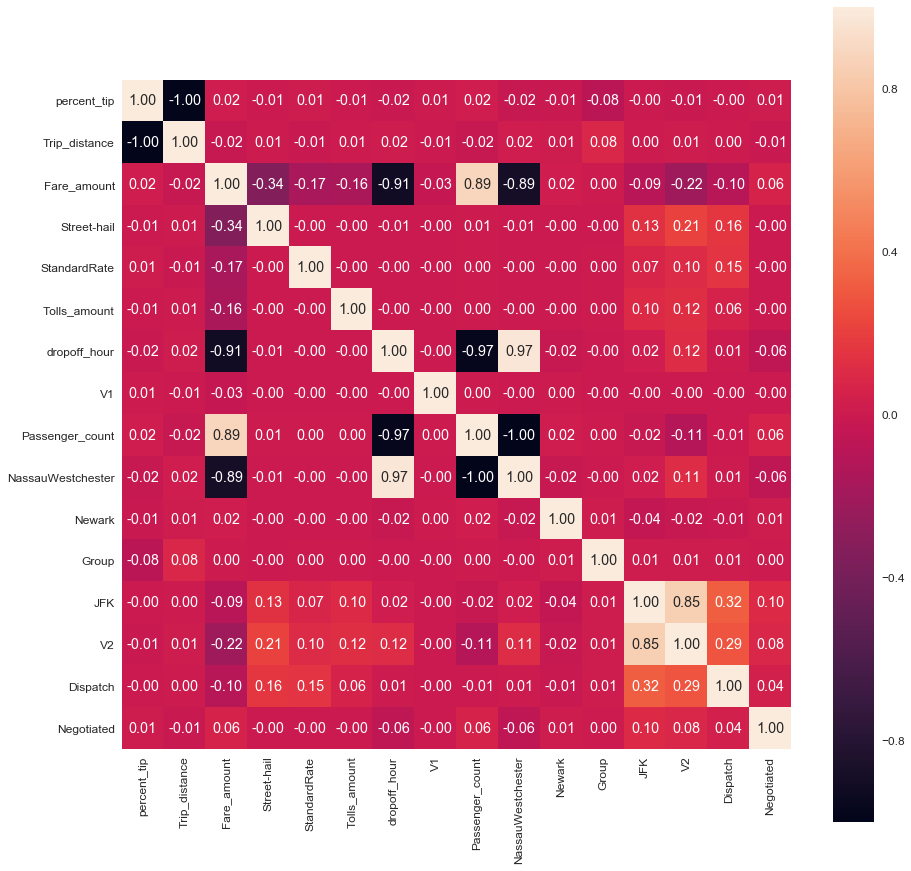

In [249]:
## This block is adapted from https://www.kaggle.com/junkal/selecting-the-best-regression-model
sns.set(rc={'figure.figsize':(15,15)})

c = model_input_data.copy()
c['percent_tip'] = model_output_data
correlation = c.corr(method='pearson')
columns = correlation.nlargest(20, 'percent_tip').index
correlation_map = np.corrcoef(c.values.T)
sns.set(font_scale=1.2)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

## This block was adapted from https://www.kaggle.com/junkal/selecting-the-best-regression-model

I don't trust this heatmap - it's showing some weird trends (e.g. -1.0 between percent tip and trip distance. Doesn't make sense). Would debug if I had more time. The purpose of this analysis is to understand which variables demonstrate correlation among themselves and which ones are likely good candidates for predicting percent_tip

## Create ML Models

We will attempt to fit the data to a couple of linear models. All will be assessed via k-fold cross validation (often with 3 folds as a tradeoff between time and generality (i.e. performance)). We begin with Ridge Regression (L2 distance with a regularization param), move on to lasso (L1 with a regularization param), then try including our polynomial features on whichever model performs better, then try elastic net, which essentially uses a cross validation technique to find the best weighted combination of the outputs of both Lasso and Ridge, then we can try random forest (a bagging (bootstrap aggregating) ensemble of decision trees), and finally Gradient Boosted Regression. 

In [22]:
# Let's try multi-fold generalized cross-validation on regularized linear regression as a baseline
RCV = RidgeCV(store_cv_values=True, alphas=(0.0001,1,10000))
RCV.fit(model_input_data, model_output_data)
print( np.array([[model_input_cols[i],RCV.coef_[i]] for i in range(len(RCV.coef_))]) )
print(RCV.cv_values_.mean(axis=0)) # per alpha MSE (hence 3 numbers)

[['V1' '0.0008658824063496112']
 ['V2' '-0.0008658824063851383']
 ['StandardRate' '0.03838480183119746']
 ['JFK' '-0.003549815826273911']
 ['Newark' '-0.011801934810288534']
 ['NassauWestchester' '-0.006212364406861351']
 ['Negotiated' '0.006031229699009084']
 ['Group' '-0.02285191648505706']
 ['Street-hail' '0.004438358599487539']
 ['Dispatch' '-0.0044383585994369115']
 ['dropoff_hour' '0.0001556708233613297']
 ['Passenger_count' '3.2474575911627315e-05']
 ['Trip_distance' '0.001698290008090289']
 ['Fare_amount' '0.0003939080627097567']
 ['Tolls_amount' '0.0018690810298111662']]
[0.00776802 0.00776802 0.00776982]


In [23]:
L = LassoCV()
L.fit(model_input_data, model_output_data)
print( np.array([[model_input_cols[i],L.coef_[i]] for i in range(len(L.coef_))]) )
mse = np.mean(L.mse_path_[np.where(L.alphas_ == L.alpha_)[0][0]])
print(mse) # only print the mse of the best alpha we chose

[['V1' '0.0012985645365800507']
 ['V2' '-1.4178967886649355e-16']
 ['StandardRate' '0.03802654682644781']
 ['JFK' '-0.0']
 ['Newark' '-0.0']
 ['NassauWestchester' '-0.0']
 ['Negotiated' '-0.0']
 ['Group' '-0.0']
 ['Street-hail' '0.0']
 ['Dispatch' '-0.0']
 ['dropoff_hour' '0.00015521234703813264']
 ['Passenger_count' '0.0']
 ['Trip_distance' '0.001755114720904462']
 ['Fare_amount' '0.0003683189175188698']
 ['Tolls_amount' '0.001686909230252523']]
0.00777486916287316


In [24]:
L = LassoCV()
L.fit(poly_input_data, model_output_data)
print( np.array([[i,L.coef_[i]] for i in range(len(L.coef_))]) )
mse = np.mean(L.mse_path_[np.where(L.alphas_ == L.alpha_)[0][0]])
print(mse) # only print the mse of the best alpha we chose

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00 -0.00000000e+00]
 [ 3.00000000e+00  0.00000000e+00]
 [ 4.00000000e+00 -0.00000000e+00]
 [ 5.00000000e+00 -0.00000000e+00]
 [ 6.00000000e+00  0.00000000e+00]
 [ 7.00000000e+00 -0.00000000e+00]
 [ 8.00000000e+00 -0.00000000e+00]
 [ 9.00000000e+00  0.00000000e+00]
 [ 1.00000000e+01 -0.00000000e+00]
 [ 1.10000000e+01 -0.00000000e+00]
 [ 1.20000000e+01 -0.00000000e+00]
 [ 1.30000000e+01  0.00000000e+00]
 [ 1.40000000e+01  0.00000000e+00]
 [ 1.50000000e+01  0.00000000e+00]
 [ 1.60000000e+01  0.00000000e+00]
 [ 1.70000000e+01  0.00000000e+00]
 [ 1.80000000e+01  0.00000000e+00]
 [ 1.90000000e+01  0.00000000e+00]
 [ 2.00000000e+01 -0.00000000e+00]
 [ 2.10000000e+01  0.00000000e+00]
 [ 2.20000000e+01  0.00000000e+00]
 [ 2.30000000e+01 -0.00000000e+00]
 [ 2.40000000e+01  0.00000000e+00]
 [ 2.50000000e+01  0.00000000e+00]
 [ 2.60000000e+01  0.00000000e+00]
 [ 2.70000000e+01  0.00000000e+00]
 [ 2.80000000e+01  0

In [25]:
EN = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
EN.fit(model_input_data, model_output_data)
print( np.array([[model_input_cols[i],EN.coef_[i]] for i in range(len(EN.coef_))]) )
mse = np.mean(EN.mse_path_, axis=1)[np.where(EN.alphas_ == EN.alpha_)[0][0]]
print(mse)
print(EN.l1_ratio_) # This ratio tells us: are we doing Lasso (close to 1) or Ridge (close to 0)

[['V1' '0.0012985645365800507']
 ['V2' '-1.4178967886649355e-16']
 ['StandardRate' '0.03802654682644781']
 ['JFK' '-0.0']
 ['Newark' '-0.0']
 ['NassauWestchester' '-0.0']
 ['Negotiated' '-0.0']
 ['Group' '-0.0']
 ['Street-hail' '0.0']
 ['Dispatch' '-0.0']
 ['dropoff_hour' '0.00015521234703813264']
 ['Passenger_count' '0.0']
 ['Trip_distance' '0.001755114720904462']
 ['Fare_amount' '0.0003683189175188698']
 ['Tolls_amount' '0.001686909230252523']]
[0.00769235 0.00784935 0.00789845]
1.0


In [26]:
EN = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
EN.fit(poly_input_data, model_output_data)
print( np.array([[i,EN.coef_[i]] for i in range(len(EN.coef_))]) )
mse = np.mean(EN.mse_path_, axis=1)[np.where(EN.alphas_ == EN.alpha_)[0][0]]
print(mse)
print(EN.l1_ratio_) # This ratio tells us: are we doing Lasso (close to 1) or Ridge (close to 0)

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00 -0.00000000e+00]
 [ 3.00000000e+00  0.00000000e+00]
 [ 4.00000000e+00 -0.00000000e+00]
 [ 5.00000000e+00 -0.00000000e+00]
 [ 6.00000000e+00  0.00000000e+00]
 [ 7.00000000e+00 -0.00000000e+00]
 [ 8.00000000e+00 -0.00000000e+00]
 [ 9.00000000e+00  0.00000000e+00]
 [ 1.00000000e+01 -0.00000000e+00]
 [ 1.10000000e+01 -0.00000000e+00]
 [ 1.20000000e+01 -0.00000000e+00]
 [ 1.30000000e+01  0.00000000e+00]
 [ 1.40000000e+01  0.00000000e+00]
 [ 1.50000000e+01  0.00000000e+00]
 [ 1.60000000e+01  0.00000000e+00]
 [ 1.70000000e+01  0.00000000e+00]
 [ 1.80000000e+01  0.00000000e+00]
 [ 1.90000000e+01  0.00000000e+00]
 [ 2.00000000e+01 -0.00000000e+00]
 [ 2.10000000e+01  0.00000000e+00]
 [ 2.20000000e+01  0.00000000e+00]
 [ 2.30000000e+01 -0.00000000e+00]
 [ 2.40000000e+01  0.00000000e+00]
 [ 2.50000000e+01  0.00000000e+00]
 [ 2.60000000e+01  0.00000000e+00]
 [ 2.70000000e+01  0.00000000e+00]
 [ 2.80000000e+01  0

In [201]:
RFR = RandomForestRegressor(random_state=0,oob_score=True,n_estimators=250)
RFR.fit(model_input_data, model_output_data)
print(RFR.oob_score_) 
# Out_of_bag score is kind of equivalent to validation acc 
# (this is the ave error across the dataset, ...
# where each datapoint is evaluated on the trees that weren't trained with that datapoint)


-0.09834856238452039


In [28]:
# # Let's try gradient boosted regression
# kf = KFold(n_splits=3,shuffle=True)
# GBR = GradientBoostingRegressor()
# for train_index, test_index in kf.split(model_output_data):
#     print(train_index)
#     print(test_index)
#     train_inputsplit  = model_input_data.loc[train_index,:]
#     train_outputsplit = model_output_data.loc[train_index,:]
#     test_inputsplit   = model_input_data.loc[test_index,:]
#     test_outputsplit  = model_output_data.loc[test_index,:]
    
#     GBR.fit(train_inputsplit, train_outputsplit)
#     print(score(test_inputsplit, test_outputsplit))
#     print(MSE(test_outputsplit, predict(test_inputsplit)))
#     print( np.array([[model_input_cols[i],feature_importances_[i]] for i in range(len(GBR.feature_importances_))]) )
# # print(RCV.cv_values_.mean(axis=0))


### Analysis

In the above models, we outputted feature importance and the error metric. Notice that the Lasso performs significantly better than most of the other models, with an MSE of 0.007 (interpretted as its predictions are off by 0.007). This means that we're predicting percent tip with an error = 0.007/0.0667 = 10% The elastic net chooses the hyperparam that fully weights the lasso. The Random Forest is relatively poorly performant, and I could not get the GBR to properly work. With more time I'd have liked to try it and perhaps even a multi layer perceptron - there seem to be some nonlinearities that are unaccounted for. 

The most important feature throughout the models seems to be whether the trip is StandardRate". Let's explore that a bit:

In [29]:
green_data.groupby('StandardRate')['percent_tip'].describe()

,count,mean,std,min,25%,50%,75%,max
StandardRate,,,,,,,,
0,36506.0,0.035435,0.095413,0.0,0.0,0.0,0.000000,1.00000
1,1451827.0,0.067423,0.088456,0.0,0.0,0.0,0.166667,0.98912


Seems like the average standardrate passenger tip is values at 3.2% more than a non-standard rate passenger!

In [30]:
green_data.loc[green_data['StandardRate'] == 0][['percent_tip','Total_amount','Tip_amount']].loc[green_data['Tip_amount']>290]


,percent_tip,Total_amount,Tip_amount
1036700,0.849143,350.0,297.2


^Wow, someone gave a generous tip...

# Explore Average Trip Speed

count    1.460108e+06
mean     1.333420e+01
std      1.043301e+01
min      1.666667e-02
25%      6.300000e+00
50%      1.048333e+01
75%      1.720000e+01
max      1.489500e+02
Name: trip_duration, dtype: float64


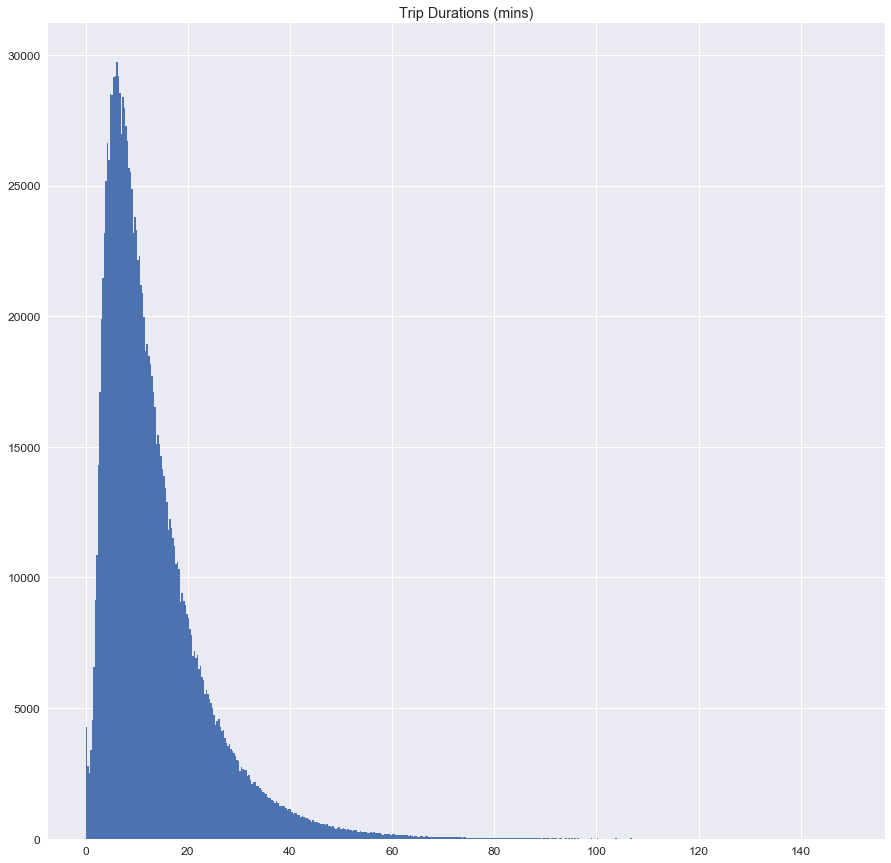

count    1.445506e+06
mean     1.285868e+01
std      5.199787e+00
min      5.600498e-03
25%      9.446739e+00
50%      1.181679e+01
75%      1.501345e+01
max      3.445438e+01
Name: Avg_speed, dtype: float64


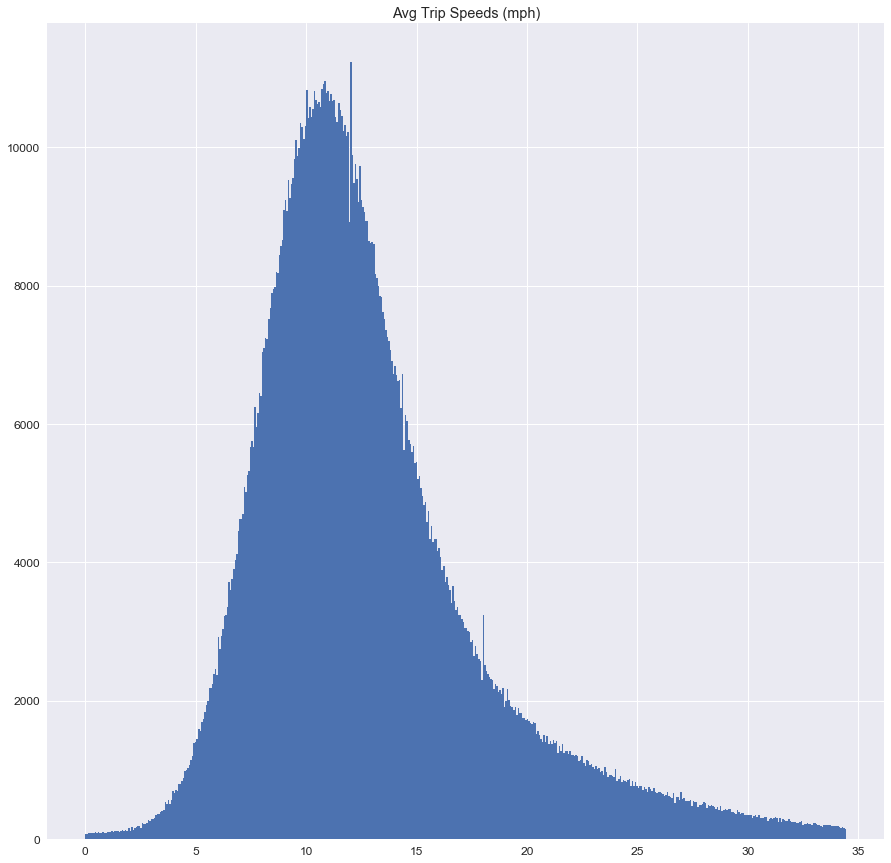

In [55]:
# create a numerical trip duration variable from the pickup/dropoff data
pickup  = green_data['lpep_pickup_datetime']
dropoff = green_data['Lpep_dropoff_datetime']
pickup  = np.array([datetime.datetime.strptime(s, "%Y-%m-%d  %H:%M:%S") for s in pickup])
dropoff = np.array([datetime.datetime.strptime(s, "%Y-%m-%d  %H:%M:%S") for s in dropoff])
green_data['trip_duration'] = dropoff - pickup
green_data['trip_duration'] = green_data['trip_duration'].values.astype(float) / 6e10 # stored in mins

# remove outliers from trip duration data, store in new inliers variable
percent_in = 0.994
inliers = green_data.loc[green_data['trip_duration'] < green_data['trip_duration'].quantile(percent_in)]

# remove all non-positive trip durations and distances
inliers = inliers.loc[inliers['trip_duration'] > 0]
inliers = inliers.loc[inliers['Trip_distance'] > 0]

# see statistics and histogram of the cleaned trip duration variable
print(inliers['trip_duration'].describe())
plt.figure()
_ = plt.hist(inliers['trip_duration'], bins=500) # hist in minutes
plt.title('Trip Durations (mins)')
plt.show()

# create a trip avg speed variable from trip distances and trip durations
inliers['Avg_speed'] = inliers['Trip_distance'] / inliers['trip_duration'] * 60.0 # in miles/hour

# remove outliers from trip duration data, modify inliers variable
percent_in = 0.99
inliers = inliers.loc[inliers['Avg_speed'] < inliers['Avg_speed'].quantile(percent_in)]

# see statistics and histogram of the cleaned avg speed variable
print(inliers['Avg_speed'].describe())
plt.figure()
_ = plt.hist(inliers['Avg_speed'],bins=500) # hist in miles/hour
plt.title('Avg Trip Speeds (mph)')
plt.show()

### Analysis

Trip durations are heavily skewed towards the left as people take taxis for short trips, not long trips. The overall speed distribution is also slightly skewed to the left, which indicates that the distances are more skewed to the left than the durations. This makes sense with NYC traffic, where short distances can (frustratingly) be really lengthy in time. I have discarded outliers to produce a more reasonable graph and not unfairly skew the mean. It's be no means a formal declaration of outliers, which we could do with something like chauvenet's criterion, but this is quick, dirty, and will suffice. 

In [111]:
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.width', 1000)

There are two ways to interpret weeks in september: the conventional definition of Sun-Sat weeks, which results in 5 non-homogeneously distributed wees, or  4 sets of 7 days, where the 29th and 30 are cutoff from the analysis

## Try 5 Weeks 

F_onewayResult(statistic=372.0120213017071, pvalue=8.17e-321)
         count       mean       std       min       25%        50%        75%        max
week                                                                                    
1     238758.0  13.003343  5.248055  0.018163  9.537313  11.890392  15.189656  34.450867
2     350036.0  12.694464  5.249622  0.024048  9.239437  11.681416  14.881188  34.452592
3     346528.0  12.707887  5.079129  0.005677  9.377483  11.697733  14.798077  34.454383
4     329649.0  13.091466  5.227316  0.005600  9.652997  12.000000  15.250366  34.451613
5     180535.0  12.850104  5.195728  0.016674  9.455389  11.854722  15.043228  34.453125


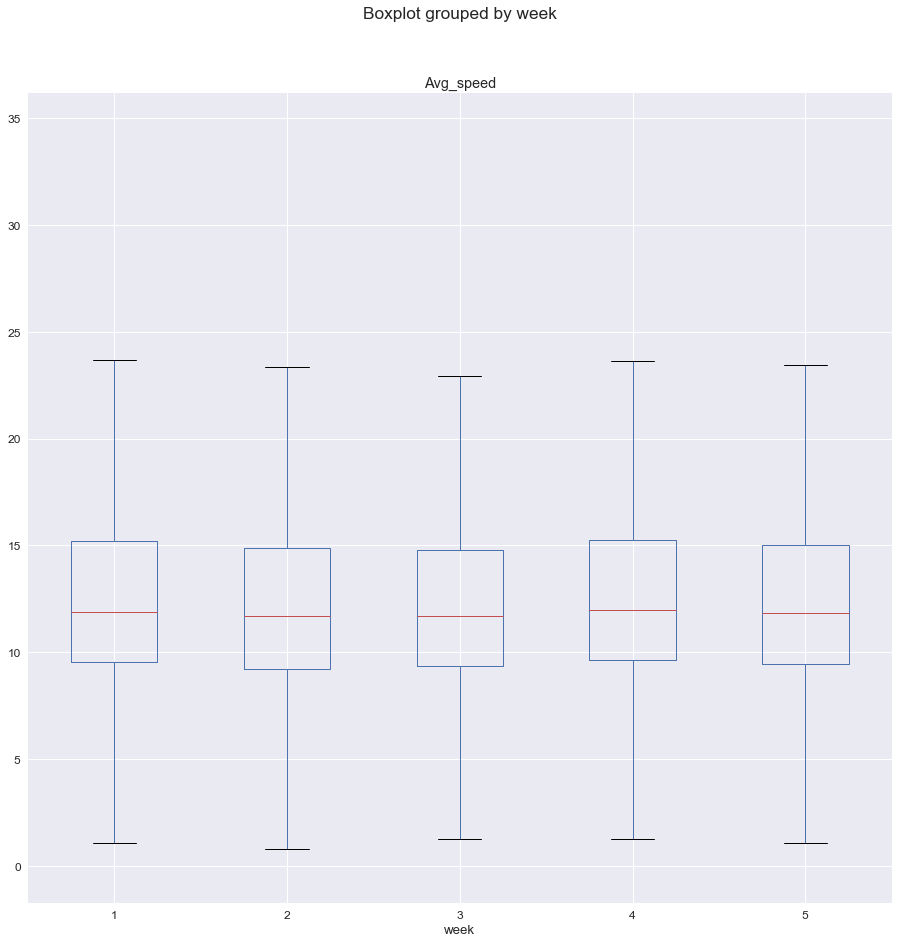

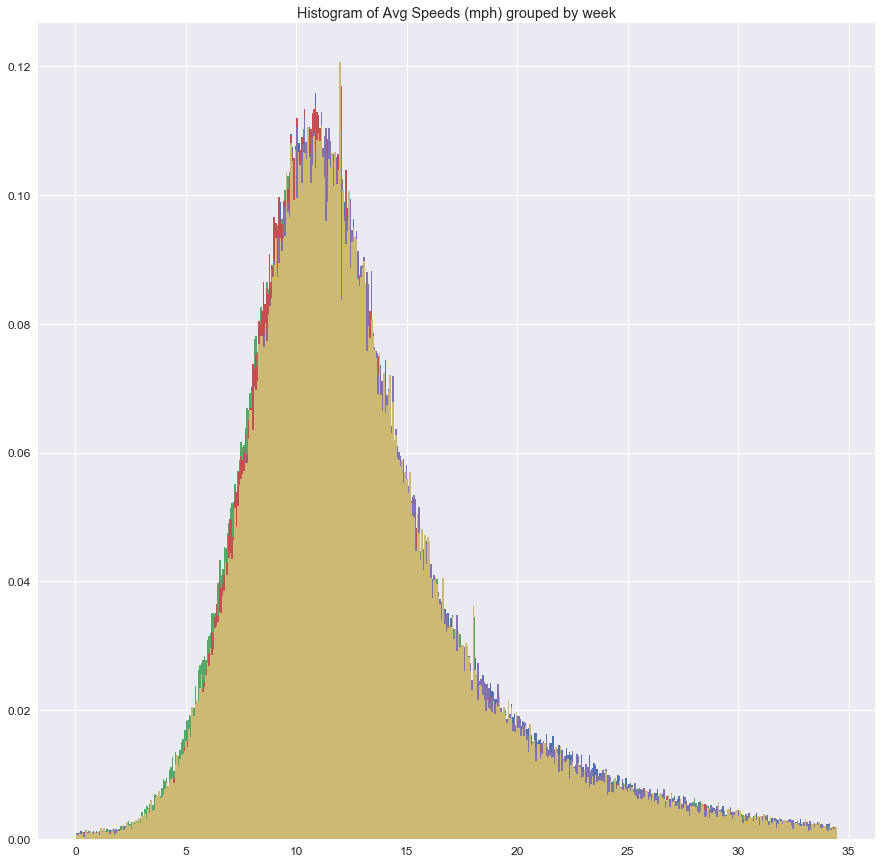

In [112]:
# generate dict to convert day to week in September
day_week = {}
for d in range(1,31):
    if d<=5: w = 1
    elif d<=12: w = 2
    elif d<=19: w = 3
    elif d<=26: w = 4
    else: w = 5
    day_week[d] = w # day is key, week is value

date_enc = '%Y-%m-%d  %H:%M:%S'
inliers['week'] = [day_week[datetime.datetime.strptime(s, date_enc).day] for s in inliers['lpep_pickup_datetime']]

gb = inliers.groupby('week').Avg_speed
week1 = gb.get_group(1)
week2 = gb.get_group(2)
week3 = gb.get_group(3)
week4 = gb.get_group(4)
week5 = gb.get_group(5)
print(stats.f_oneway(week1, week2, week3, week4, week5))
print(inliers.groupby('week')['Avg_speed'].describe())
plt.figure()
_ = inliers.boxplot(by='week',column='Avg_speed')
plt.figure()
plt.title('Histogram of Avg Speeds (mph) grouped by week')
_ = inliers.groupby('week')['Avg_speed'].hist(normed=True,bins=500)

### Analysis

The ANOVA tells us that there is significantly faster trips in the 1st and 4th weeks. This means that traffic was slower during the 2nd/3rd weeks, which is when there was labor day and when schools open and are in session again. 

## Try 4 weeks

F_onewayResult(statistic=2370.329278872141, pvalue=0.0)
         count       mean       std       min       25%        50%        75%        max
week                                                                                    
1     330583.0  13.389674  5.344717  0.018163  9.854015  12.262009  15.650067  34.450867
2     349402.0  12.508273  5.149008  0.008596  9.135158  11.513126  14.626944  34.454383
3     351184.0  12.577446  5.075620  0.005677  9.251797  11.579764  14.671968  34.451939
4     326886.0  13.163091  5.224439  0.005600  9.725806  12.086331  15.340909  34.453125


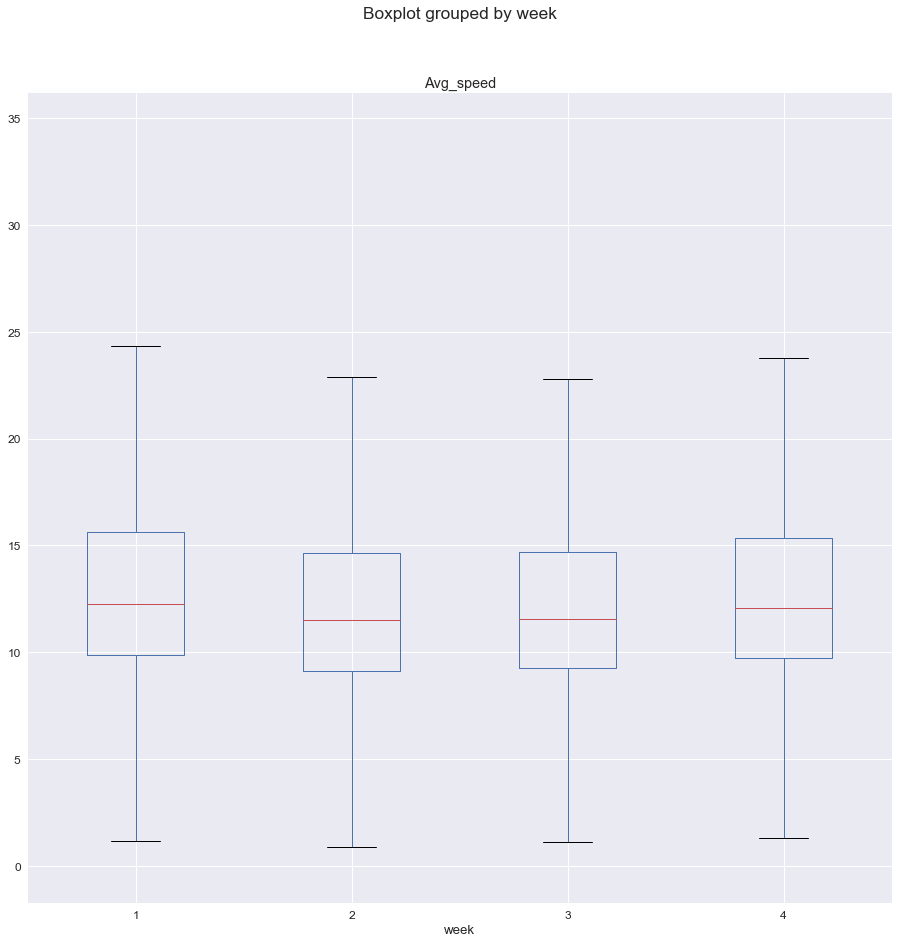

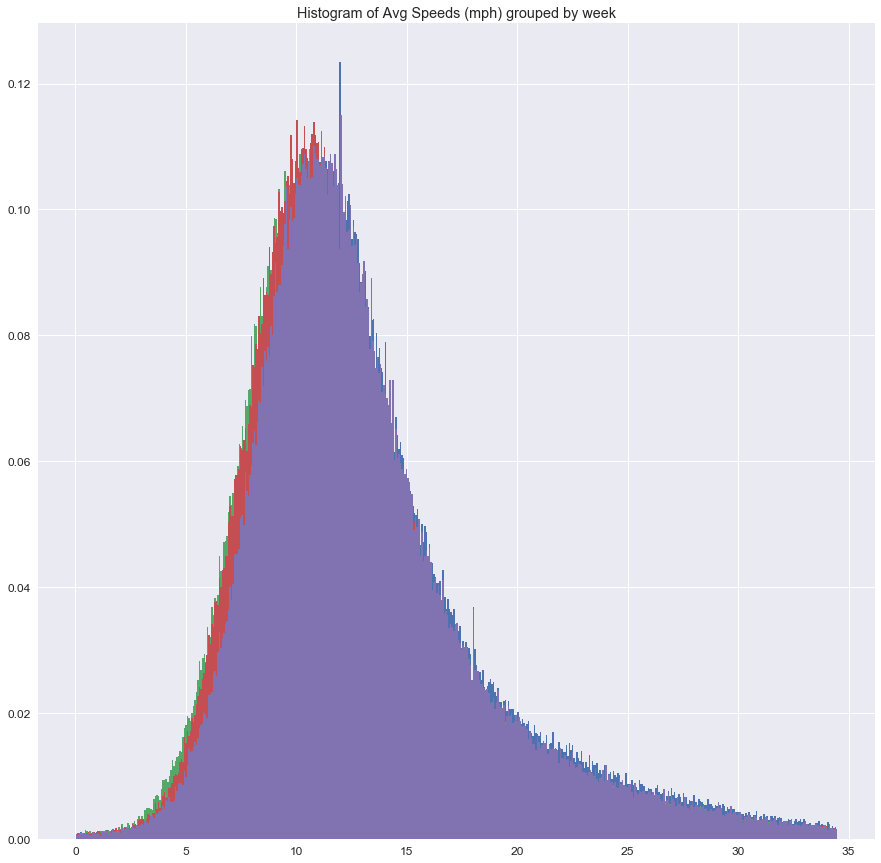

In [110]:
# generate dict to convert day to week in September
day_week = {}
for d in range(1,31):
    if d<=7: w = 1
    elif d<=14: w = 2
    elif d<=21: w = 3
    elif d<=28: w = 4
    else: w = 0 # dummy in place so we know to remove these later
    day_week[d] = w # day is key, week is value

date_enc = '%Y-%m-%d  %H:%M:%S'
inliers['week'] = [day_week[datetime.datetime.strptime(s, date_enc).day] for s in inliers['lpep_pickup_datetime']]
speed_data = inliers.loc[inliers.week != 0]

gb = speed_data.groupby('week').Avg_speed
week1 = gb.get_group(1)
week2 = gb.get_group(2)
week3 = gb.get_group(3)
week4 = gb.get_group(4)
print(stats.f_oneway(week1, week2, week3, week4))
print(speed_data.groupby('week')['Avg_speed'].describe())
plt.figure()
_ = speed_data.boxplot(by='week',column='Avg_speed')
plt.figure()
plt.title('Histogram of Avg Speeds (mph) grouped by week')
_ = speed_data.groupby('week')['Avg_speed'].hist(normed=True,bins=500)

### Analysis

The ANOVA tells us that there is significantly faster trips in the 1st and 4th weeks. This means that traffic was slower during the 2nd/3rd weeks, which is when there was labor day and when schools open and are in session again. Same analysis as the other separation of days 

In [143]:
def get_minute_of_day(datestring):
    date_enc = '%Y-%m-%d  %H:%M:%S'
    dateobj = datetime.datetime.strptime(datestring, date_enc)
    hour = int(dateobj.hour)
    minutes_past_hour = int(dateobj.minute)
    return 60.0*hour + minutes_past_hour
inliers['mins_past_midnight'] = [get_minute_of_day(s) for s in inliers['lpep_pickup_datetime']]

count    1.445506e+06
mean     8.444557e+02
std      4.076949e+02
min      0.000000e+00
25%      5.570000e+02
50%      9.280000e+02
75%      1.181000e+03
max      1.439000e+03
Name: mins_past_midnight, dtype: float64



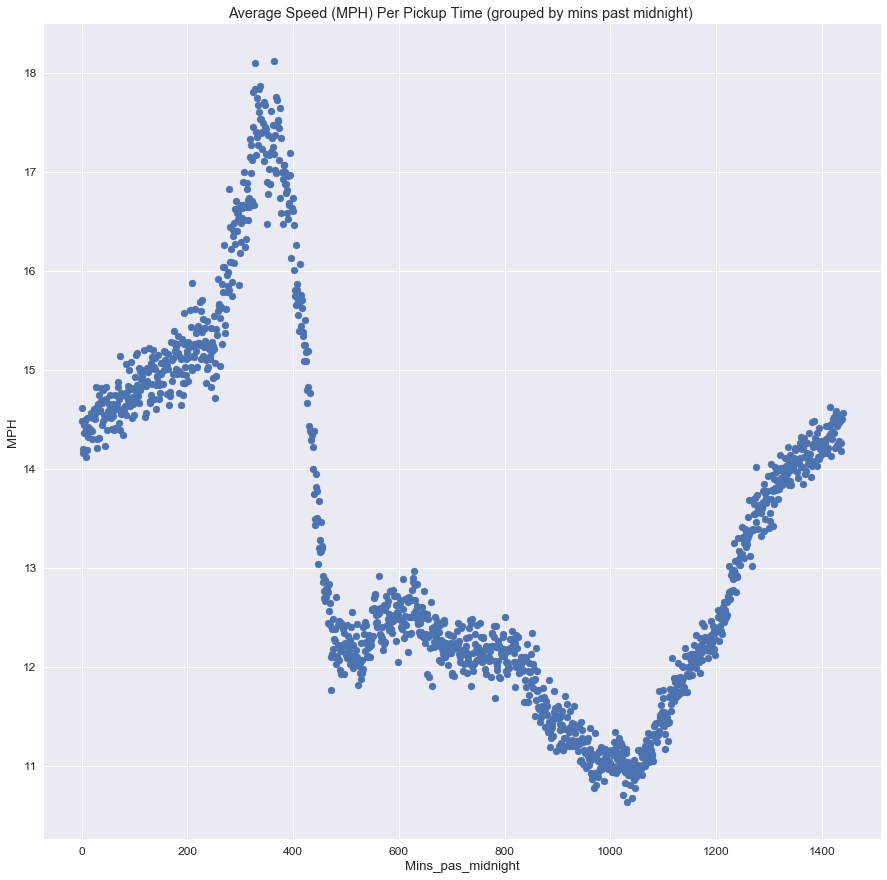

In [162]:
print(inliers['mins_past_midnight'].describe())
mean_speed_per_min = inliers.groupby('mins_past_midnight')['Avg_speed'].mean()
plt.figure()
plt.title('Average Speed (MPH) Per Pickup Time (grouped by mins past midnight) ')
plt.ylabel('MPH')
plt.xlabel('Mins_pas_midnight')
plt.scatter([i for i in range(len(mean_speed_per_min))], mean_speed_per_min)
print()


In [154]:
EN = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
EN.fit(inliers['mins_past_midnight'].reshape(-1, 1), inliers['Avg_speed'])
print( np.array([[i,EN.coef_[i]] for i in range(len(EN.coef_))]) )
mse = np.mean(EN.mse_path_, axis=1)[np.where(EN.alphas_ == EN.alpha_)[0][0]]
print(mse)
print(EN.l1_ratio_) # are we doing Lasso (close to 1) or Ridge (close to 0)

[[ 0.         -0.00132935]]
[27.94303077 25.66875528 26.76661747]
0.1


In [168]:
RFR = RandomForestRegressor(random_state=0,oob_score=True,n_estimators=250)
RFR.fit(inliers['mins_past_midnight'].reshape(-1, 1), inliers['Avg_speed'])
print(RFR.oob_score_) 
# Out_of_bag score is kind of equivalent to validation acc 
# (this is the ave MSE on the data fed into the trees that weren't trained with that data)


0.07512285837278421


### Analysis

Here the Random forest regressor is quite decent at predicting MPH based on minute of day the trip started. This is within an error of 0.07/12.8 = 5.5% of the expected value. The linear regression model obviously does worse because it tries to fit to the scatter plot above, which is clearly not linear. Random Forest's nonlinearity makes it an ideal choice for this regression model. 

Also notice that trip speeds peak around 5-6am and are lowest during evening rush hour. This makes perfect sense. 